Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import all necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import time
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
torch.manual_seed(101)

Get MNIST train and test datasets:

Below commands download and store the MNIST dataset automatically and also normalize the images. The commands 
also convert them to pytorch tensors and shuffle all the samples.

If you have downloaded data manually, then upon loading you will find that images are comprised of pixels
represented by 8-bits. So, the brightness of a pixel is represented by a number ranging from 0 (implying completely black pixel) 
to 2^8-1 = 255 (implying completely white pixel). You can normalize the images in that case by simply dividing them by 255 

In [ ]:
Transform = transforms.ToTensor()
mnist_trainset = datasets.MNIST("../MyDrive/Advanced_ML/data", train=True, download=True, transform=Transform)
mnist_testset = datasets.MNIST("../MyDrive/Advanced_ML/data", train=False, download=True, transform=Transform)

In [ ]:
mnist_trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../MyDrive/Advanced_ML/data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
mnist_testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../MyDrive/Advanced_ML/data
    Split: Test
    StandardTransform
Transform: ToTensor()

Visualizing an example:

As shown below the pixels are normalized.Normalizing the data across all the dimensions (28x28=784 in this case) is really necessary.
This ensures that a single or a few dimensions don't significantly affect your training steps.
Normalization also increases stability of the training procedure.

Similarly, shuffling of data is also necessary.
Shuffling the data serves the purpose of reducing variance and making sure that models remain generalized and overfit less.

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

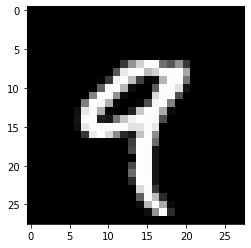

In [ ]:
train_image,train_label = mnist_trainset[4]
plt.imshow(train_image.reshape((28,28)),cmap="gray")

train_image


Initialize train and test data loaders:

DataLoader function creates mini-batches of relevant batch size from the training and test-sets. It creates an iterator, a data structure (https://www.w3schools.com/python/python_iterators.asp) from which mini-batches can be yielded one after another.
Shuffling of data is also necessary.Shuffling data serves the purpose of reducing variance and making sure that models remain general and overfit less. 

In [ ]:
BATCH_SIZE = 1000
TEST_BATCH_SIZE = 10000
train_data_loader = DataLoader(mnist_trainset,batch_size = BATCH_SIZE,shuffle = True)
test_data_loader = DataLoader(mnist_testset,batch_size = TEST_BATCH_SIZE,shuffle = False)

Multi layer Perceptron model with 2 hidden layers

Here we are defining our Multi-Layer Perceptron as a class called MLP. The MLP class is declared as a child class of the nn.Module base class. MLP inherits many of the attributes and methods from nn.Module through the statement super().__init__()

Our MLP has 2 hidden layers, with the size of layers being 784, 110, 74 and 10 respectively starting from the input layer.
All layers except the last layer use ReLU as non-linear activation.

The output layer consists of a log softmax operation. Softmax is a mathematical function which takes a vector of N (10 in our case) real numbers as input and converts it into a probability distribution. It is a generalized form of logistic function of N probabilities proportional to the exponential of input numbers, that is, before applying softmax, the vector components can be negative or greater than 0.
But after applying softmax, each component will be in the interval [0,1], and the components will add up to 1, so that we can interpret 
these values as probabilities.
"The term softmax is used because this activation function represents a smooth version of the winner-takes-all activation model in 
which the unit with the largest input has output +1 while all other units have output 0."
As the numbers are too big the exponents will probably blow up (computer cannot handle such big numbers) giving Nan as output. Also,
dividing by large numbers can be numerically unstable.Log softmax is advantageous over softmax for improved numerical performance 
and gradient optimization.
Source: https://medium.com/@AbhiramiVS/softmax-vs-logsoftmax-eb94254445a2

In [ ]:
class MLP(nn.Module):
    def __init__(self,n_features = 784,n_classes=10,layers=[110,74]):
        super().__init__()
        self.fullconnected1 = nn.Linear(n_features,layers[0])
        self.fullconnected2 = nn.Linear(layers[0],layers[1])
        self.fullconnected3 = nn.Linear(layers[1],n_classes)
    def forward(self,x):
        x = F.relu(self.fullconnected1(x))
        x = F.relu(self.fullconnected2(x))
        x = self.fullconnected3(x)
        return F.log_softmax(x,dim=1)

In [ ]:
'''
Instantiate from MLP class
'''
mlp_model = MLP()
print(mlp_model)

MLP(
  (fullconnected1): Linear(in_features=784, out_features=110, bias=True)
  (fullconnected2): Linear(in_features=110, out_features=74, bias=True)
  (fullconnected3): Linear(in_features=74, out_features=10, bias=True)
)


Loss function and optimizer:

The loss function to be optimized is Cross-entropy loss. A popular function used to calculate distance between two probability distributions.
This is optimized using ADAM optimizer here, a version of Stochastic Gradient Descent. Read additional resources in Moodle to learn more about ADAM optimizer.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(),lr = 0.01)

Training and testing the model:

optimizer.zero_grad() makes stored gradient values of all the learnable parameters 0 before starting back-propagation for each mini-batch.
PyTorch accumulates the gradients on subsequent backward passes. This accumulating behaviour is convenient while training models like RNNs or when we want to compute the gradient of the loss summed over multiple mini-batches. This is not required here.

loss.backward() does the actual backpropagation and calculates all the relevant gradients.

optimizer.step() updates the parameters accoring to the optimizer chosen (ADAM in this case)

"with torch.no_grad():" context ensures that gradients are not accumulated while feeding samples from test or validation set.




In [ ]:
epochs = 10
train_counter = []
test_counter = []
train_loss = []
test_loss = []

for epoch in range(epochs):
    train_corr = 0
    test_corr = 0

    for batch_idx, (train_image,train_label) in enumerate(train_data_loader):
        batch_idx+=1
        prediction = mlp_model(train_image.view(BATCH_SIZE,-1))
        loss = criterion(prediction,train_label)

        predicted_counter = torch.max(prediction.data,1)[1]
        batch_corr = (predicted_counter == train_label).sum()
        train_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx%(60000/BATCH_SIZE) == 0:
            print(f'Train Epoch: {epoch:2} batch: {batch_idx:4} [{BATCH_SIZE*batch_idx:6}/60000] Train Loss: {loss.item():10.6f} Train Accuracy: {train_corr.item()*100/60000:.3f}%')

    train_loss.append(loss.detach().numpy())
    train_counter.append(train_corr)

    with torch.no_grad():
        for batch_idx, (test_image,test_label) in enumerate(test_data_loader):
            validation = mlp_model(test_image.view(TEST_BATCH_SIZE,-1))

            validated = torch.max(validation.data,1)[1]
            test_corr+= (validated == test_label).sum()

        loss = criterion(validation,test_label)
        test_loss.append(loss)
        test_counter.append(test_corr)

Train Epoch:  0 batch:   60 [ 60000/60000] Train Loss:   0.203381 Train Accuracy: 85.793%
Train Epoch:  1 batch:   60 [ 60000/60000] Train Loss:   0.158904 Train Accuracy: 95.500%
Train Epoch:  2 batch:   60 [ 60000/60000] Train Loss:   0.101560 Train Accuracy: 96.853%
Train Epoch:  3 batch:   60 [ 60000/60000] Train Loss:   0.068663 Train Accuracy: 97.617%
Train Epoch:  4 batch:   60 [ 60000/60000] Train Loss:   0.068853 Train Accuracy: 98.155%
Train Epoch:  5 batch:   60 [ 60000/60000] Train Loss:   0.094966 Train Accuracy: 98.493%
Train Epoch:  6 batch:   60 [ 60000/60000] Train Loss:   0.023397 Train Accuracy: 98.633%
Train Epoch:  7 batch:   60 [ 60000/60000] Train Loss:   0.054614 Train Accuracy: 98.782%
Train Epoch:  8 batch:   60 [ 60000/60000] Train Loss:   0.019384 Train Accuracy: 98.863%
Train Epoch:  9 batch:   60 [ 60000/60000] Train Loss:   0.015971 Train Accuracy: 98.932%


In [ ]:
print(f'Test Accuracy: {test_counter[-1].item()*100/10000:.3f}%')

Test Accuracy: 97.540%


In [ ]:
np.array(train_loss)

array([0.2033813 , 0.15890414, 0.10155977, 0.06866342, 0.06885263,
       0.09496556, 0.02339669, 0.05461412, 0.0193836 , 0.01597136],
      dtype=float32)

Plot losses

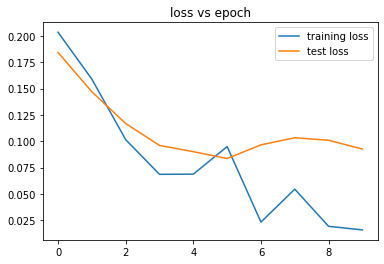

In [ ]:
plt.plot(train_loss,label = 'training loss')
plt.plot(test_loss,label = 'test loss')
plt.title('loss vs epoch')

plt.legend()

In [ ]:
np.array(train_counter)
np.array(train_counter)

array([51476, 57300, 58112, 58570, 58893, 59096, 59180, 59269, 59318,
       59359])

Both training and test accuracy are well above 96% after training for 10 epochs. Test accuracy is close to training accuracy. This is a sign that our training has gone well. 
Test accuracy is also slightly lower than training accuracy. This indicates slight overfitting. A slight overfitting is expected. However, the difference between training and test accuracy shouldn't be too large

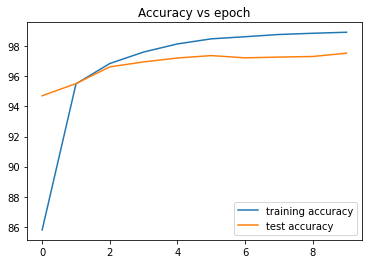

In [ ]:
plt.plot((np.array(train_counter)/60000)*100,label = 'training accuracy')
plt.plot((np.array(test_counter)/10000)*100,label = 'test accuracy')
plt.title('Accuracy vs epoch')

plt.legend()